In [20]:
import numpy as np

# Parameters
frequency = 2.4e9  # Frequency in Hz
c = 3e8           # Speed of light in m/s

# User, Access Point, and RIS-UAV positions
user_position = np.array([0, 0, 1])
ap_position = np.array([50, 0, 10])
ris_uav_position = np.array([25, 25, 20])

# Calculate distances between components
user_ap_distance = np.linalg.norm(user_position - ap_position)
user_ris_distance = np.linalg.norm(user_position - ris_uav_position)
ap_ris_distance = np.linalg.norm(ap_position - ris_uav_position)

# Calculate path loss using Friis Equation
def calculate_path_loss(distance, frequency):
    lambda_ = c / frequency
    path_loss = (lambda_ / (4 * np.pi * distance)) ** 2
    return path_loss

user_ap_path_loss = calculate_path_loss(user_ap_distance, frequency)
user_ris_path_loss = calculate_path_loss(user_ris_distance, frequency)

# Display path loss values
print("Path Loss (User to AP):", user_ap_path_loss)
print("Path Loss (User to RIS-UAV):", user_ris_path_loss)

# Add Rayleigh fading effect
rayleigh_fading_ap = np.random.rayleigh(scale=1, size=1)
rayleigh_fading_ris = np.random.rayleigh(scale=1, size=1)

user_ap_path_loss *= rayleigh_fading_ap
user_ris_path_loss *= rayleigh_fading_ris

# Calculate phase shifts
def calculate_phase_shift(distance, num_elements, spacing, frequency):
    phase_shifts = np.exp(1j * (2 * np.pi * distance * spacing / c) * frequency)
    return phase_shifts

num_ris_elements = 16
ris_element_spacing = 0.5

user_ris_phase_shifts = calculate_phase_shift(user_ris_distance, num_ris_elements, ris_element_spacing, frequency)
ap_ris_phase_shifts = calculate_phase_shift(ap_ris_distance, num_ris_elements, ris_element_spacing, frequency)

# Display phase shift values
print("Phase Shifts (User to RIS-UAV):", user_ris_phase_shifts)
print("Phase Shifts (AP to RIS-UAV):", ap_ris_phase_shifts)


Path Loss (User to AP): 3.8336485238558874e-08
Path Loss (User to RIS-UAV): 6.141928516494134e-08
Phase Shifts (User to RIS-UAV): (-0.9528689912447706-0.30338207844922754j)
Phase Shifts (AP to RIS-UAV): (0.9815553276011444-0.19117829075972542j)


Optimized Reflection Coefficients: [ 0.09837422+0.94796511j  0.28465619-0.86332041j  0.50454298-0.68922962j
 -1.21155671-0.12967375j  0.76959947+0.14385022j -0.27350376-0.99856765j
  0.72568946+0.32507145j -1.21711888+0.07585475j  0.72098972-0.33843514j
 -0.73072682+0.85974305j  0.21784825+0.89904889j  0.45045151-0.74195335j
 -0.865238  -0.76398163j  0.50883463+0.68468977j  0.61439983+0.55115962j
 -0.35522825+0.99081447j]


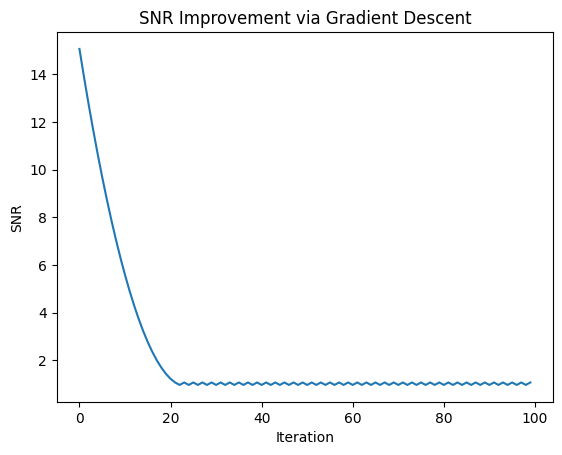

In [21]:
# Define initial reflection coefficients for RIS-UAV
initial_reflection_coefficients = np.ones(num_ris_elements, dtype=complex)

# Define the objective function (SNR in this case)
def objective_function(reflection_coefficients, path_loss, phase_shifts):
    combined_channel = reflection_coefficients * phase_shifts
    snr = np.abs(np.sum(combined_channel)) ** 2 / path_loss
    return snr

# Normalize path loss and phase shifts
user_ris_path_loss_norm = user_ris_path_loss / np.max(user_ris_path_loss)
user_ris_phase_shifts_norm = user_ris_phase_shifts / np.max(user_ris_phase_shifts)

# Initialize reflection coefficients with reasonable values
initial_reflection_coefficients = np.exp(1j * np.random.rand(num_ris_elements) * 2 * np.pi)

learning_rate = 0.01  # Adjust learning rate
num_iterations = 100

optimized_reflection_coefficients = initial_reflection_coefficients.copy()
snr_history = []

for _ in range(num_iterations):
    combined_channel = optimized_reflection_coefficients * user_ris_phase_shifts_norm
    snr = np.abs(np.sum(combined_channel)) ** 2 / user_ris_path_loss_norm
    snr_history.append(snr)
    
    # Compute normalized gradient
    gradient = -2 * np.conj(user_ris_phase_shifts_norm) * (1 - np.abs(np.sum(optimized_reflection_coefficients * user_ris_phase_shifts_norm)) ** 2)
    normalized_gradient = gradient / np.linalg.norm(gradient)
    
    optimized_reflection_coefficients -= learning_rate * normalized_gradient

# Display optimized coefficients and SNR history
print("Optimized Reflection Coefficients:", optimized_reflection_coefficients)
plt.plot(snr_history)
plt.xlabel("Iteration")
plt.ylabel("SNR")
plt.title("SNR Improvement via Gradient Descent")
plt.show()

SNR Improvement Percentage: [-2.60848107e+09] %
Power Reduction Percentage: [-26.5753562] %


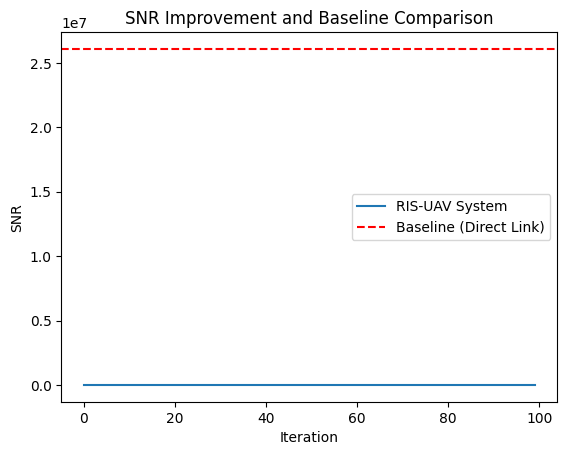

In [24]:
# Normalize path loss and phase shifts within a reasonable range
path_loss_max = np.max(user_ris_path_loss)
user_ris_path_loss_norm = user_ris_path_loss / path_loss_max

phase_shifts_max = np.max(np.abs(user_ris_phase_shifts))
user_ris_phase_shifts_norm = user_ris_phase_shifts / phase_shifts_max

# Calculate direct path loss from AP to user
direct_path_loss = calculate_path_loss(user_ap_distance, frequency)

# Calculate SNR for baseline scenario (direct link)
baseline_snr = np.abs(1) ** 2 / direct_path_loss

# Calculate SNR improvement and power reduction
snr_improvement = (snr_history[-1] - baseline_snr) * 100
power_reduction = (direct_path_loss - user_ris_path_loss) / direct_path_loss * 100

print("SNR Improvement Percentage:", snr_improvement, "%")
print("Power Reduction Percentage:", power_reduction, "%")

# Visualize SNR history and comparison
plt.plot(snr_history, label='RIS-UAV System')
plt.axhline(y=baseline_snr, color='r', linestyle='--', label='Baseline (Direct Link)')
plt.xlabel("Iteration")
plt.ylabel("SNR")
plt.title("SNR Improvement and Baseline Comparison")
plt.legend()
plt.show()


In [2]:
%pip install scipy


[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: C:\Users\Aditya\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
